In [1]:
%load_ext autoreload
%autoreload 2 
%matplotlib agg

import matplotlib.pyplot as plt
import numpy as np
import visualization
from data import datasets, evaluation
import transformation
import jax
import jax.numpy as jnp
from jax import tree_util
from transformation import MLP
import flax.linen as nn
from flax.core import freeze
import optax
from inference import point_estimate

rng_key = jax.random.PRNGKey(0)

In [2]:
# load samples
rng_key, rng_key_ = jax.random.split(rng_key)
samples_parameters = jax.random.permutation(rng_key_, np.load("mlp_3_1_sinusoidal_0_6.npy"))
print(samples_parameters.shape)

(262144, 10)


In [28]:
embedding_dim = 4

encoder = MLP([10, embedding_dim], activation=nn.tanh)
decoder = MLP([10, 10], activation=nn.tanh)
encoder_parameters = encoder.init(rng_key_, jnp.ones((1, 10)))
decoder_parameters = decoder.init(rng_key_, jnp.ones((1, embedding_dim)))

rng_key, rng_key_ = jax.random.split(rng_key)
parameters = {
    "encoder": encoder_parameters,
    "decoder": decoder_parameters,
    "log_std": 0.0
}

In [29]:
X = samples_parameters[:4096]

In [30]:
def ridge_loss(params, x, y):
    std = jnp.exp(params["log_std"])
    encoded = encoder.apply(params["encoder"], x)
    x_hat = decoder.apply(params["decoder"], encoded)
    squared_loss = jnp.power(y - x_hat, 2).sum()
    reg_encoder = tree_util.tree_reduce(
        lambda a, b: a + b,
        tree_util.tree_map(lambda a: jnp.power(a, 2).sum(), params["encoder"])
    )
    reg_decoder = tree_util.tree_reduce(
        lambda a, b: a + b,
        tree_util.tree_map(lambda a: jnp.power(a, 2).sum(), params["decoder"])
    )
    regularization = reg_encoder + reg_decoder
    loss = (0.5 / jnp.power(std, 2)) * squared_loss + (x.shape[0] ** 2) * jnp.log(std) + regularization
    return loss

def mse_loss(params, x, y):
    encoded = encoder.apply(params["encoder"], x)
    x_hat = decoder.apply(params["decoder"], encoded)
    squared_loss = jnp.power(y - x_hat, 2).sum()
    loss = 0.5 * squared_loss
    return loss

In [31]:
# optimization
optimizer = optax.adam(learning_rate=0.001)
optimizer_state = optimizer.init(parameters)

In [36]:
parameters, optimizer_state = point_estimate(
    loss_function=jax.jit(ridge_loss),
    parameters=parameters,
    inputs=X,
    outputs=X,
    epochs=9001,
    optimizer=optimizer,
    optimizer_state=optimizer_state,
    report_at=100
)

epoch 0 loss: -16748698.0
epoch 100 loss: -18427080.0
epoch 200 loss: -20103104.0
epoch 300 loss: -21775972.0
epoch 400 loss: -23445174.0
epoch 500 loss: -25110404.0
epoch 600 loss: -26771226.0
epoch 700 loss: -28427204.0
epoch 800 loss: -30077540.0
epoch 900 loss: -31721996.0
epoch 1000 loss: -33358210.0
epoch 1100 loss: -34984128.0
epoch 1200 loss: -36597484.0
epoch 1300 loss: -38197128.0
epoch 1400 loss: -39778612.0
epoch 1500 loss: -41339108.0
epoch 1600 loss: -42874684.0
epoch 1700 loss: -44381580.0
epoch 1800 loss: -45851944.0
epoch 1900 loss: -47279356.0
epoch 2000 loss: -48656608.0
epoch 2100 loss: -49975376.0
epoch 2200 loss: -51226556.0
epoch 2300 loss: -52400744.0
epoch 2400 loss: -53487936.0
epoch 2500 loss: -54478836.0
epoch 2600 loss: -55365432.0
epoch 2700 loss: -56141188.0
epoch 2800 loss: -56802788.0
epoch 2900 loss: -57349724.0
epoch 3000 loss: -57786972.0
epoch 3100 loss: -58123456.0
epoch 3200 loss: -58371804.0
epoch 3300 loss: -58547064.0
epoch 3400 loss: -58664616

In [37]:
encoded = encoder.apply(parameters["encoder"], X)
X_hat = decoder.apply(parameters["decoder"], encoded)

In [38]:
print(X.shape)
print(X_hat.shape)

(4096, 10)
(4096, 10)


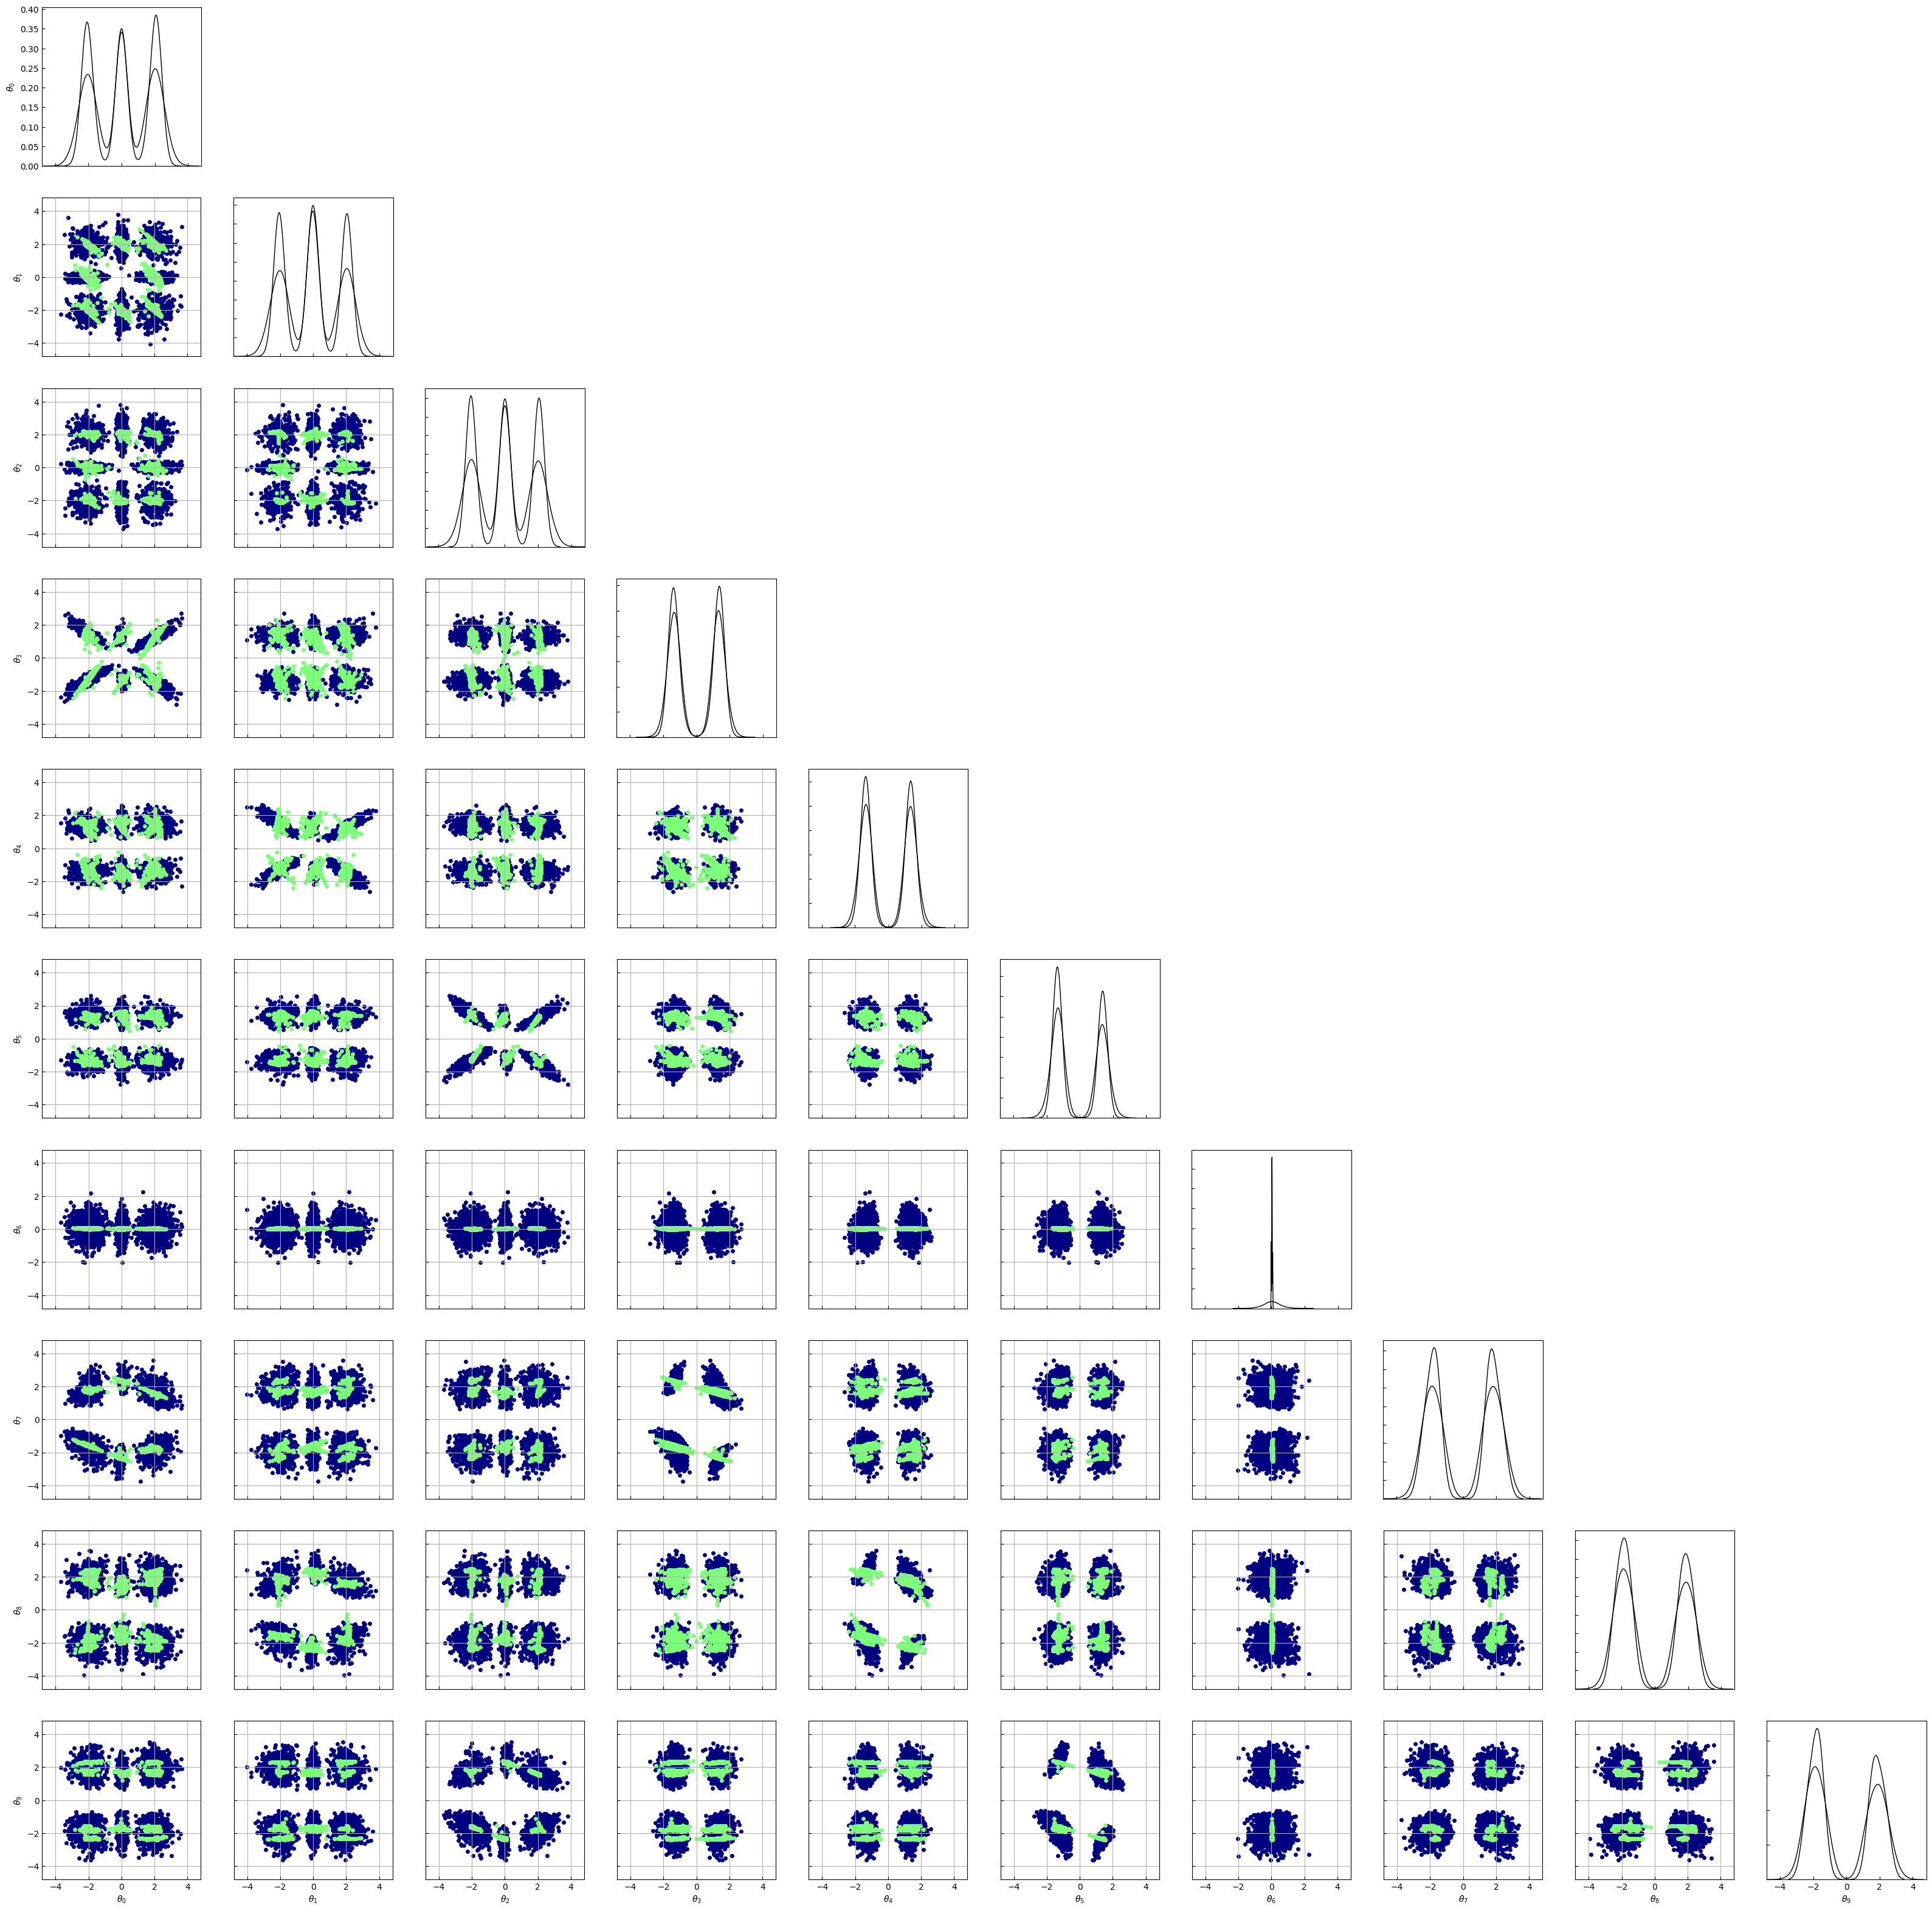

In [39]:
figure = visualization.TriangleFigure(
    prefix=r"\theta",
    ax_width=4.0,
    ax_height=4.0,
    settings=visualization.TriangleSettings(
        scatter_settings=visualization.ScatterSettings(alpha=1.0, size=16.0)
    )
)
figure.plot(data_list=[X, X_hat])